# Segmentation of Toronto

## Task 1: Scrap and wrangle data from wiki url 

In [189]:
# Import all libraries that will be used for the assignment
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
from pandas.io.json import json_normalize

In [190]:
# Get data from the url
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url, timeout=100)
soup = BeautifulSoup(page.text, 'html.parser')
table = soup.find('table', {'class':'wikitable sortable'})

In [191]:
# Get table headers and rows
# Headers
headers = []
for row in table.findAll('th'):
    h = row.text.rstrip()
    headers.append(h)
# Rows
c1, c2, c3 = [], [], []
for row in table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells) == 3:
        c1.append(cells[0].find(text=True).strip())
        c2.append(cells[1].find(text=True).strip())
        c3.append(cells[2].find(text=True).strip())
print(headers)

['Postal Code', 'Borough', 'Neighbourhood']


In [192]:
# Create a data frame
d = dict([(x,0) for x in headers])
d['Postal Code'] = c1
d['Borough'] = c2
d['Neighbourhood'] = c3
df = pd.DataFrame(d)
df = df[df['Borough'] != 'Not assigned']
df.head(10)

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill, Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


Notes: It seems that someone already updated the wiki source, since M5A example already is listed in a single row with its neighborhoods separated by a comma. There is also no single row with a borough but a not assigned neigborhood.

In [193]:
# Use shape
df.shape

(103, 3)

## Task 2: Add geo location to postal codes  

First I will try to get the latitude and longitude values using the geocoder as explained in the submission section.

In [194]:
#pip install geocoder
#import geocoder
#ll = []
#for pc in df['Postal Code']:
#    lat_lng_coords = None
#    print('{}, Toronto, Ontario, Canada'.format(pc))
#    c = 0
#    while(lat_lng_coords is None):
#        g = geocoder.google('{}, Toronto, Ontario'.format(pc))
#        lat_lng_coords = g.latlng
#        c = c+1
#    print(lat_lng_coords, c)
#    ll.append(lat_lng_coords)
#ll

The geocoder approach does not work. The first postal code never returns an answer different to none. For that reason, I´m using the provided csv directly.

In [195]:
# Get the csv file into a dataframe
geodata = pd.read_csv('http://cocl.us/Geospatial_data')
geodata.head(2)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497


In [196]:
# Merge postal code data with geo data
data = pd.merge(df, geodata, how='left', on='Postal Code')
data.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## Task 3: Explore and cluster 

In [197]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [198]:
# Four Square Settings
CLIENTID = 'WREO4NKKMNSIKMPPPCMZGDL1EN5H4AVPB30A2LGB12ER2R4G'
CLIENTSECRET = 'PCBYU51DGC0SBSPILGHAFI4TVRKKTGBA45LTOW1N1C1FPTAR'
VERSION = '20200605'
R = 500
LIMIT = 100

Folium library was installed and credentials needed to call Four Square Api set.

Recreating the functions from the lab. First function retrieves the category name of the venue from the venue.categories section. Second function gets all nearby venues for each of the postal codes, together with their categories. Third function wrangles data structure to a single row per postal code and a variable number of columns for the most common venues categories.

In [199]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
          return None
    else:
        return categories_list[0]['name']

In [200]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENTID, CLIENTSECRET, lat, lon, VERSION, R, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['groups'][0]['items']
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in venues])
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['N', 'NLat', 'NLng', 'V', 'VLat', 'VLng', 'VCategory']
    return nearby_venues

In [201]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [202]:
# Call functions and get the venues nearby each of the postal codes
data['N'] = data['Postal Code'] + '-' + data['Borough']
data_names = data.loc[:, 'N']
data_lat = data.loc[:, 'Latitude']
data_lng = data.loc[:, 'Longitude']
toronto_venues = getNearbyVenues(data_names, data_lat, data_lng, 500)

print(len(toronto_venues))
print('There are {} unique venue categories'.format(len(toronto_venues['VCategory'].unique())))
toronto_venues.head(2)

3208
There are 180 unique venue categories


,N,NLat,NLng,V,VLat,VLng,VCategory
0,M3A-North York,43.753259,-79.329656,Oriole York Mills United Church,43.751552,-79.384650,Concert Hall
1,M3A-North York,43.753259,-79.329656,The Durdy Bayramov Art Foundation,43.755435,-79.385294,Music Venue


In [203]:
# Transform into data frame with one row per postal code and one column for each venue category
toronto_onehot = pd.get_dummies(toronto_venues[['VCategory']], prefix='', prefix_sep='')
toronto_onehot['N'] = toronto_venues['N']
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('N').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head(2)

(101, 181)


,N,Adult Boutique,American Restaurant,Aquarium,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1B-Scarborough,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C-Scarborough,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [204]:
# Get data frame with one row per postal code and the most common types of venues
num_top_venues = 12
indicators = ['st', 'nd', 'rd']
columns = ['N']

for ind in np.arange(num_top_venues):
    try: 
        columns.append('{}{}'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th'.format(ind+1))

n_venues_sorted = pd.DataFrame(columns=columns)
n_venues_sorted['N'] = toronto_grouped['N']

for ind in np.arange(toronto_grouped.shape[0]):
    n_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

n_venues_sorted.head(2)

,N,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th,12th
0,M1B-Scarborough,Park,Pizza Place,Pharmacy,Coffee Shop,Bank,Sandwich Place,Liquor Store,Yoga Studio,Flower Shop,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
1,M1C-Scarborough,Japanese Restaurant,Café,Bank,Chinese Restaurant,Yoga Studio,Escape Room,Fried Chicken Joint,Food Court,Food & Drink Shop,Flower Shop,Fast Food Restaurant,Falafel Restaurant


In [205]:
# Cluster Neighborhoods
kclusters = 12
toronto_grouped_clustering = toronto_grouped.drop('N', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
n_venues_sorted.insert(0, 'ClusterLabel', kmeans.labels_)
toronto_merged = data
toronto_merged = toronto_merged.join(n_venues_sorted.set_index('N'), on='N')
toronto_merged = toronto_merged[~toronto_merged['ClusterLabel'].isnull()]
toronto_merged.head(2)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,N,ClusterLabel,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th,12th
0,M3A,North York,Parkwoods,43.753259,-79.329656,M3A-North York,4.0,Intersection,Concert Hall,Music Venue,Yoga Studio,Electronics Store,Fried Chicken Joint,Food Court,Food & Drink Shop,Flower Shop,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,M4A-North York,9.0,Bus Line,Bookstore,Café,College Quad,Trail,Coffee Shop,Yoga Studio,Escape Room,Food Court,Food & Drink Shop,Flower Shop,Fast Food Restaurant


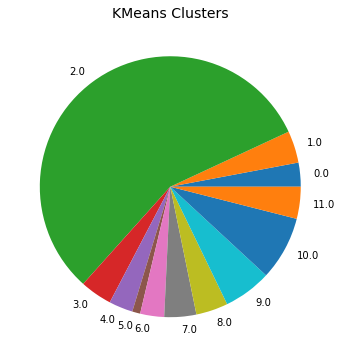

In [206]:
# Pie graph that counts for each cluster label
pie = toronto_merged.groupby('ClusterLabel')['Postal Code'].count()
fig, ax = plt.subplots(figsize=[10,6])
labels = pie.keys()
plt.pie(x=pie, labels=labels, pctdistance=0.5)
plt.title("KMeans Clusters", fontsize=14)
plt.show()

In [207]:
# Visualize clusters on map
map_clusters = folium.Map(location=[43.72, -79.3809], zoom_start= 12)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lng, pc, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['N'], toronto_merged['ClusterLabel']):
    cluster = int(cluster)
    label = folium.Popup(str(pc) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7, parse_html=False).add_to(map_clusters)

map_clusters

In [208]:
# Check for some cluster
toronto_merged.loc[toronto_merged['ClusterLabel'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,N,ClusterLabel,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th,12th
2,Downtown Toronto,M5A-Downtown Toronto,2.0,Clothing Store,Coffee Shop,Restaurant,Plaza,Theater,Bubble Tea Shop,Hotel,Pizza Place,Diner,Cosmetics Shop,Middle Eastern Restaurant,Opera House
4,Downtown Toronto,M7A-Downtown Toronto,2.0,Coffee Shop,Japanese Restaurant,Gay Bar,Sandwich Place,Pizza Place,Diner,Mexican Restaurant,Juice Bar,Liquor Store,Lounge,Martial Arts School,Men's Store
5,Etobicoke,M9A-Etobicoke,2.0,Coffee Shop,Japanese Restaurant,Restaurant,Gay Bar,Sushi Restaurant,Burger Joint,Gym,Café,Hotel,Dessert Shop,Thai Restaurant,Smoke Shop
6,Scarborough,M1B-Scarborough,2.0,Park,Pizza Place,Pharmacy,Coffee Shop,Bank,Sandwich Place,Liquor Store,Yoga Studio,Flower Shop,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
7,North York,M3B-North York,2.0,Coffee Shop,Bank,Butcher,Burger Joint,Supermarket,General Entertainment,Sandwich Place,Baseball Field,Park,Ice Cream Shop,Bus Stop,Cosmetics Shop


In [210]:
toronto_merged.loc[toronto_merged['ClusterLabel'] == 10, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,N,ClusterLabel,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th,12th
10,North York,M6B-North York,10.0,Italian Restaurant,Supermarket,Kids Store,Coffee Shop,Beer Store,Yoga Studio,Electronics Store,Food Court,Food & Drink Shop,Flower Shop,Fast Food Restaurant,Falafel Restaurant
23,East York,M4G-East York,10.0,Italian Restaurant,Supermarket,Kids Store,Beer Store,Yoga Studio,Escape Room,Fried Chicken Joint,Food Court,Food & Drink Shop,Flower Shop,Fast Food Restaurant,Falafel Restaurant
44,Scarborough,M1L-Scarborough,10.0,Italian Restaurant,Road,Supermarket,Kids Store,Coffee Shop,Beer Store,Yoga Studio,Electronics Store,Food Court,Food & Drink Shop,Flower Shop,Fast Food Restaurant
49,North York,M6L-North York,10.0,Beer Store,Italian Restaurant,Supermarket,Grocery Store,Kids Store,Pharmacy,Dog Run,Park,Yoga Studio,Food & Drink Shop,Flower Shop,Fast Food Restaurant
51,Scarborough,M1M-Scarborough,10.0,Pharmacy,Dog Run,Bus Line,Park,Grocery Store,Food & Drink Shop,Flower Shop,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Escape Room,Electronics Store
